# Seldon and TensorRT Inference Server MNIST Example

This example shows how you can combine Seldon with the NVIDIA TensorRT Inference Server. We will use a Seldon TensorRT proxy model image that will forward Seldon internal microservice prediction calls out to an external TensorRT Inference Server.

This example will:

 * Show the packaging of the components using S2I

# Setup

In [10]:
%matplotlib inline
import requests
from random import randint,random
import json
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data


/home/clive/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

def download_mnist():
    return input_data.read_data_sets("MNIST_data/", one_hot = True)

def rest_predict_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/predict",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_input_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-input",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_transform_output_request(endpoint,data):
    request = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+endpoint+"/transform-output",
                data={"json":json.dumps(request),"isDefault":True})
    return response.json()   

def rest_request_ambassador(deploymentName,endpoint="localhost:8003",arr=None):
    payload = {"data":{"names":["a","b"],"tensor":{"shape":[1,784],"values":arr.tolist()}}}
    response = requests.post(
                "http://"+endpoint+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload)
    print(response.status_code)
    print(response.text)


def gen_mnist_data(mnist):
    batch_xs, batch_ys = mnist.train.next_batch(1)
    chosen=0
    gen_image(batch_xs[chosen]).show()
    data = batch_xs[chosen].reshape((1,784))
    return data


In [17]:
mnist = download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Create an Nvidia Model Repository

Fetch pretrained MNIST model ready for serving and place in model repository

In [9]:
!wget -O tensorrt_mnist/1/model.plan http://seldon-public.s3.amazonaws.com/nvidia-mnist-model/model.plan

--2018-09-20 14:18:52--  http://seldon-public.s3.amazonaws.com/nvidia-mnist-model/model.plan
Resolving seldon-public.s3.amazonaws.com (seldon-public.s3.amazonaws.com)... 52.218.48.249
Connecting to seldon-public.s3.amazonaws.com (seldon-public.s3.amazonaws.com)|52.218.48.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1731864 (1.7M) [binary/octet-stream]
Saving to: ‘tensorrt_mnist/1/model.plan’

tensorrt_mnist/1/mo 100%[===================>]   1.65M   148KB/s    in 12s     

2018-09-20 14:19:05 (136 KB/s) - ‘tensorrt_mnist/1/model.plan’ saved [1731864/1731864]



To run your Mvidia Inference Server you will need to upload to a google bucket the model repository in mnsit_tensorrt_model. Follow the steps below:

In [10]:
# CHANGE THIS TO YOUR OWN CHOSEN GOOGLE BUCKET NAME
%env MODEL_REPOSITORY_BUCKET=seldon-inference-server-model-store

env: MODEL_REPOSITORY_BUCKET=seldon-inference-server-model-store


In [5]:
!gsutil mb gs://${MODEL_REPOSITORY_BUCKET}

Creating gs://seldon-inference-server-model-store/...
ServiceException: 409 Bucket seldon-inference-server-model-store already exists.


In [11]:
!gsutil cp -r tensorrt_mnist gs://${MODEL_REPOSITORY_BUCKET}

Copying file://tensorrt_mnist/config.pbtxt [Content-Type=application/octet-stream]...
Copying file://tensorrt_mnist/config.pbtxt~ [Content-Type=application/octet-stream]...
Copying file://tensorrt_mnist/mnist_labels.txt [Content-Type=text/plain]...     
Copying file://tensorrt_mnist/1/model.plan [Content-Type=application/octet-stream]...
\ [4 files][  1.7 MiB/  1.7 MiB]                                                
Operation completed over 4 objects/1.7 MiB.                                      


# Test Locally From Docker with Standalone NVIDIA Inference Server

## Create your Nvidia Inference Server

For example:

 * Follow the steps in the [Kubeflow guide](https://github.com/kubeflow/kubeflow/tree/master/kubeflow/nvidia-inference-server) to create your Nvidia Inference Server 
   * You will need to use the Google Bucket location

## Package and run a Transformer and Nvidia Proxy

In [12]:
!s2i build . seldonio/seldon-core-s2i-python3:0.2 mnist-caffe2-transformer:0.1

---> Installing application source...
Build completed successfully


In [29]:
!docker run --name "mnist-transformer" -d --rm -p 5000:5000 mnist-caffe2-transformer:0.1

f2ce59df93344847d070d4218d6bccb5a7d1dab48120967a2e213435a69dce9c


** CHANGE THE IP ADDRESS BELOW TO THAT OF YOUR RUNNING NVIDIA SERVER **

In [30]:
!docker run --name "tensorrt-proxy" -d --rm -p 5001:5001 \
    -e PREDICTIVE_UNIT_SERVICE_PORT=5001 \
    -e PREDICTIVE_UNIT_PARAMETERS='[{"name":"url","type":"STRING","value":"35.204.115.6:8000"},{"name":"model_name","type":"STRING","value":"tensorrt_mnist"},{"name":"protocol","type":"STRING","value":"HTTP"}]' \
    seldonio/nvidia-inference-server-proxy:0.1

3bcca7450fadcbb8d54f90af0b40c32f26b875938b742451a4365ced0c5d3ccf


In [31]:
TRANSFORMER_URL="localhost:5000"
PREDICTOR_URL="localhost:5001"

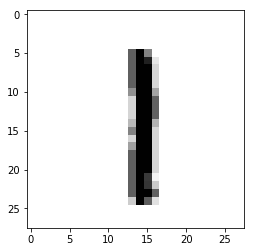

(1, 28, 28)


In [32]:
data = gen_mnist_data(mnist)
response = rest_transform_input_request(TRANSFORMER_URL,data)
transformed = np.array(response['data']['ndarray'])
print(transformed.shape)

In [33]:
response = rest_predict_request(PREDICTOR_URL,transformed)
predictions = np.array(response["data"]["ndarray"])
print(predictions)

[[[[6.36274109e-08]]

  [[9.99982357e-01]]

  [[1.35594092e-07]]

  [[2.00526298e-08]]

  [[1.17960089e-05]]

  [[8.07224509e-08]]

  [[4.73712625e-08]]

  [[4.78241873e-06]]

  [[6.21992911e-07]]

  [[9.71163061e-08]]]]


In [34]:
response = rest_transform_output_request(TRANSFORMER_URL,predictions)
print(response)

{'data': {'names': None, 'ndarray': [[6.362741089560586e-08, 0.9999823570251465, 1.3559409239860543e-07, 2.005262977888833e-08, 1.1796008948294912e-05, 8.072245094581376e-08, 4.737126246823209e-08, 4.782418727700133e-06, 6.219929105100164e-07, 9.711630610809152e-08]]}}


In [35]:
!docker rm -f mnist-transformer
!docker rm -f tensorrt-proxy

mnist-transformer
tensorrt-proxy


# Test From GCP Cluster

In [1]:
!kubectl -n kube-system create sa tiller
!kubectl create clusterrolebinding tiller --clusterrole cluster-admin --serviceaccount=kube-system:tiller
!helm init --service-account tiller

serviceaccount "tiller" created
clusterrolebinding "tiller" created
$HELM_HOME has been configured at /home/clive/.helm.

Tiller (the Helm server-side component) has been installed into your Kubernetes Cluster.

Please note: by default, Tiller is deployed with an insecure 'allow unauthenticated users' policy.
To prevent this, run `helm init` with the --tiller-tls-verify flag.
For more information on securing your installation see: https://docs.helm.sh/using_helm/#securing-your-helm-installation
Happy Helming!


In [2]:
!kubectl rollout status deploy/tiller-deploy -n kube-system

Waiting for rollout to finish: 0 of 1 updated replicas are available...
deployment "tiller-deploy" successfully rolled out


In [3]:
!helm install ../../../helm-charts/seldon-core-crd --name seldon-core-crd \
    --set usage_metrics.enabled=true

NAME:   seldon-core-crd
LAST DEPLOYED: Fri Sep 21 18:35:50 2018
NAMESPACE: default
STATUS: DEPLOYED

RESOURCES:
==> v1/ConfigMap
NAME                     DATA  AGE
seldon-spartakus-config  3     1s

==> v1beta1/CustomResourceDefinition
NAME                                         AGE
seldondeployments.machinelearning.seldon.io  1s

==> v1beta1/Deployment
NAME                        DESIRED  CURRENT  UP-TO-DATE  AVAILABLE  AGE
seldon-spartakus-volunteer  1        1        1           0          1s

==> v1/ServiceAccount
NAME                        SECRETS  AGE
seldon-spartakus-volunteer  1        1s

==> v1beta1/ClusterRole
NAME                        AGE
seldon-spartakus-volunteer  1s

==> v1beta1/ClusterRoleBinding
NAME                        AGE
seldon-spartakus-volunteer  0s

==> v1/Pod(related)
NAME                                         READY  STATUS             RESTARTS  AGE
seldon-spartakus-volunteer-7d9895b6fb-qj5gb  0/1    ContainerCreating  0         0s


NOTES:
NOTES: TODO


In [4]:
!kubectl create namespace seldon

namespace "seldon" created


In [5]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "gke_kubeflow-testing-213813_europe-west4-a_cluster-1" modified.


In [8]:
!helm install ../../../helm-charts/seldon-core --name seldon-core \
        --namespace seldon \
        --set ambassador.enabled=true

NAME:   seldon-core
LAST DEPLOYED: Fri Sep 21 18:39:02 2018
NAMESPACE: seldon
STATUS: DEPLOYED

RESOURCES:
==> v1/ServiceAccount
NAME    SECRETS  AGE
seldon  1        0s

==> v1beta1/ClusterRole
NAME        AGE
seldon-crd  0s

==> v1beta1/RoleBinding
NAME        AGE
ambassador  0s

==> v1/Pod(related)
NAME                                                 READY  STATUS             RESTARTS  AGE
seldon-core-ambassador-778c58bf5d-nf6k7              0/2    ContainerCreating  0         0s
seldon-core-seldon-apiserver-55d6c56db6-q9zgh        0/1    ContainerCreating  0         0s
seldon-core-seldon-cluster-manager-6cc6df8d97-9v98f  0/1    ContainerCreating  0         0s
seldon-core-redis-5f6bc97f64-wmtgz                   0/1    ContainerCreating  0         0s

==> v1/ClusterRoleBinding
NAME    AGE
seldon  0s

==> v1beta1/Role
NAME          AGE
ambassador    0s
seldon-local  0s

==> v1/RoleBinding
NAME    AGE
seldon  0s

==> v1/Service
NAME                          TYPE       CLUSTER-IP     E

In [9]:
!kubectl rollout status deploy/seldon-core-seldon-cluster-manager
!kubectl rollout status deploy/seldon-core-seldon-apiserver

deployment "seldon-core-seldon-cluster-manager" successfully rolled out
deployment "seldon-core-seldon-apiserver" successfully rolled out


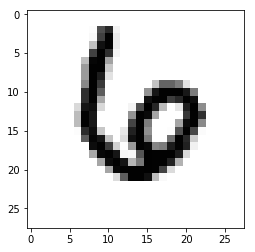

200
{
  "meta": {
    "puid": "tdgm8otah0elfdl684d3lun7d6",
    "tags": {
    },
    "routing": {
      "mnist-transformer": -1
    }
  },
  "data": {
    "names": ["t:0", "t:1", "t:2", "t:3", "t:4", "t:5", "t:6", "t:7", "t:8", "t:9"],
    "tensor": {
      "shape": [1, 10, 1, 1],
      "values": [1.8369570398135693E-7, 8.680414026462913E-12, 2.002098790573892E-12, 9.281598926935697E-13, 1.913971425793193E-9, 8.389226202609734E-9, 0.9999997615814209, 5.704471617296036E-12, 7.415959846213127E-9, 6.981141359441168E-11]
    }
  }
}


In [22]:
data = gen_mnist_data(mnist)
data = data.reshape((784))
rest_request_ambassador("nvidia-mnist",endpoint="localhost:8003",arr=data)